C:\Users\pc\AppData\Local\Temp\ipykernel_12972\2699116634.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed
C:\Users\pc\AppData\Local\Temp\ipykernel_12972\2699116634.py:19: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=1).reset_index()



Missing values before cleaning:
Date         0
Ticker       0
Close        0
High         0
Low          0
Open         0
Volume       0
Adj_Close    0
dtype: int64

Missing values after cleaning:
Date         0
Ticker       0
Close        0
High         0
Low          0
Open         0
Volume       0
Adj_Close    0
dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_12972\2699116634.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


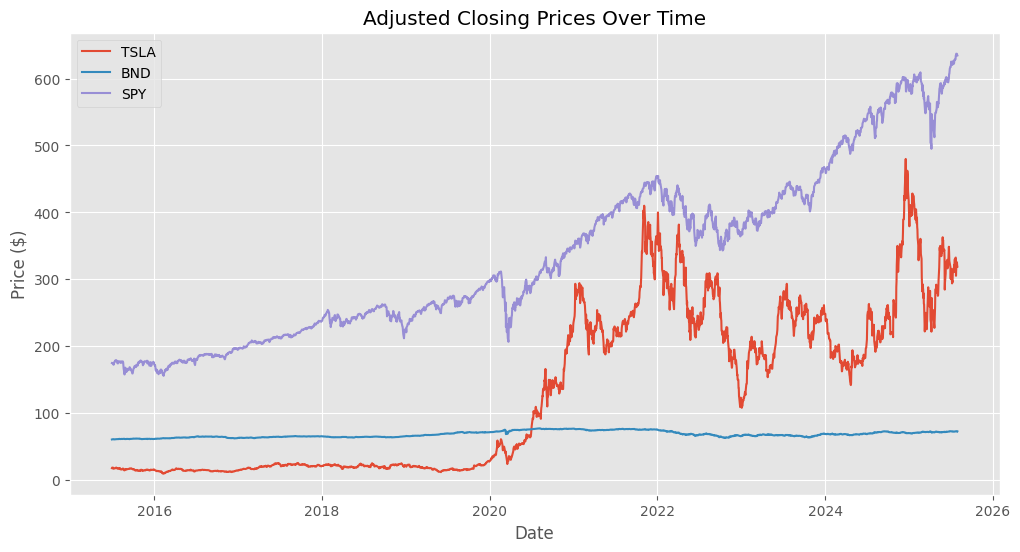

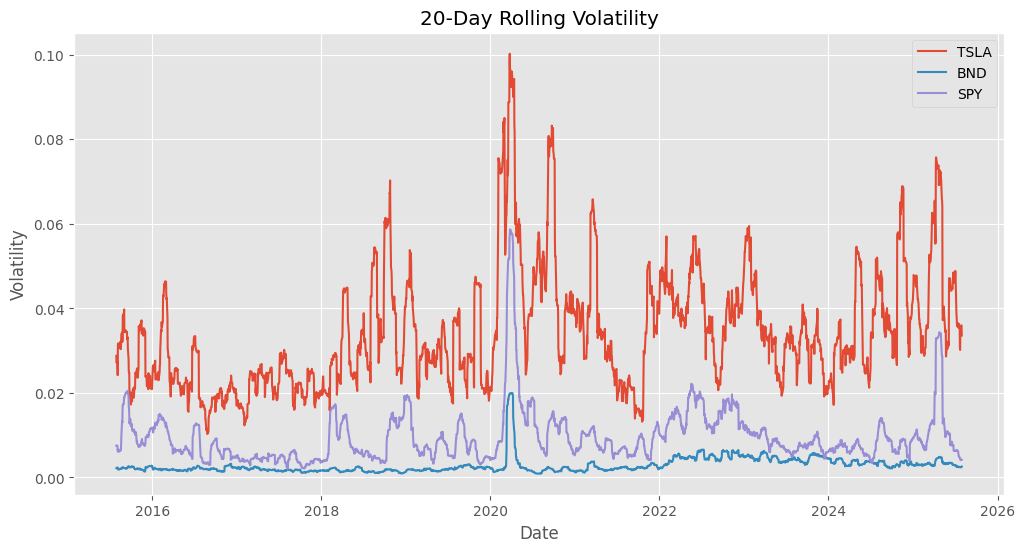


Cleaned data saved to financial_data_clean.csv


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")   # or "classic"


# 2. Data Fetching
tickers = ["TSLA", "BND", "SPY"]
start_date = "2015-07-01"
end_date = "2025-07-31"

print("Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date)

# 3. Reshape from wide to long
if isinstance(data.columns, pd.MultiIndex):
    data = data.stack(level=1).reset_index()
    data = data.rename(columns={"level_1": "Ticker"})

# 4. Clean column names
data.columns = [col.replace(" ", "_") for col in data.columns]

# 5. Ensure Adjusted Close exists
if "Adj_Close" not in data.columns:
    data["Adj_Close"] = data["Close"]

# 6. Sort and reset index
data.sort_values(["Ticker", "Date"], inplace=True)
data.reset_index(drop=True, inplace=True)

# 7. Handle missing values
print("\nMissing values before cleaning:")
print(data.isnull().sum())
data.fillna(method="ffill", inplace=True)
print("\nMissing values after cleaning:")
print(data.isnull().sum())

# 8. Feature Engineering
data["Daily_Return"] = data.groupby("Ticker")["Adj_Close"].pct_change()
data["Rolling_Volatility"] = data.groupby("Ticker")["Daily_Return"].rolling(window=20).std().reset_index(level=0, drop=True)

# 9. Plot Closing Prices
plt.figure(figsize=(12,6))
for ticker in tickers:
    subset = data[data["Ticker"] == ticker]
    plt.plot(subset["Date"], subset["Adj_Close"], label=ticker)
plt.title("Adjusted Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# 10. Plot Rolling Volatility
plt.figure(figsize=(12,6))
for ticker in tickers:
    subset = data[data["Ticker"] == ticker]
    plt.plot(subset["Date"], subset["Rolling_Volatility"], label=ticker)
plt.title("20-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# 11. Save processed data
data.to_csv("financial_data_clean.csv", index=False)
print("\nCleaned data saved to financial_data_clean.csv")




Outliers detected:
           Date Ticker  Daily_Return
6376 2020-09-08   TSLA     -0.210628
6254 2020-03-16   TSLA     -0.185778
6227 2020-02-05   TSLA     -0.171758
6256 2020-03-18   TSLA     -0.160344
7506 2025-03-10   TSLA     -0.154262
...         ...    ...           ...
6257 2020-03-19   TSLA      0.183877
6501 2021-03-09   TSLA      0.196412
6225 2020-02-03   TSLA      0.198949
7415 2024-10-24   TSLA      0.219190
7528 2025-04-09   TSLA      0.226900

[184 rows x 3 columns]


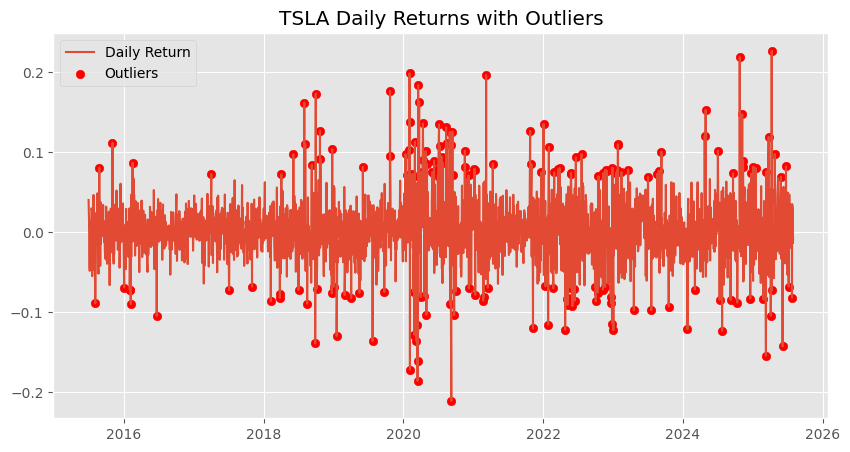

In [3]:
# Identify days with unusually high or low returns (3 standard deviations from mean)
outlier_threshold = 3
outliers = data[(data['Daily_Return'] - data['Daily_Return'].mean()).abs() > outlier_threshold * data['Daily_Return'].std()]

print("\nOutliers detected:")
print(outliers[['Date', 'Ticker', 'Daily_Return']].sort_values(by='Daily_Return'))

# Plot outliers for TSLA
plt.figure(figsize=(10,5))
tsla = data[data["Ticker"] == "TSLA"]
plt.plot(tsla["Date"], tsla["Daily_Return"], label="Daily Return")
plt.scatter(outliers[outliers["Ticker"]=="TSLA"]["Date"], 
            outliers[outliers["Ticker"]=="TSLA"]["Daily_Return"], 
            color='red', label="Outliers")
plt.title("TSLA Daily Returns with Outliers")
plt.legend()
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("✅ Stationary (reject null hypothesis)")
    else:
        print("❌ Non-stationary (fail to reject null hypothesis)")
    print()

# Run for TSLA Adj Close and Daily Return
tsla = data[data["Ticker"] == "TSLA"]
adf_test(tsla["Adj_Close"], title="TSLA Adj Close Prices")
adf_test(tsla["Daily_Return"], title="TSLA Daily Returns")


Augmented Dickey-Fuller Test: TSLA Adj Close Prices
ADF Statistic : -1.4188720053968273
p-value : 0.5731959514207222
# Lags Used : 27
# Observations : 2507
❌ Non-stationary (fail to reject null hypothesis)

Augmented Dickey-Fuller Test: TSLA Daily Returns
ADF Statistic : -34.68109047254185
p-value : 0.0
# Lags Used : 1
# Observations : 2532
✅ Stationary (reject null hypothesis)



In [5]:
import numpy as np

# Value at Risk (95%)
VaR_95 = tsla["Daily_Return"].quantile(0.05)
print(f"TSLA 95% VaR: {VaR_95:.4f}")

# Sharpe Ratio (assuming 252 trading days/year, risk-free rate = 0)
sharpe_ratio = (tsla["Daily_Return"].mean() / tsla["Daily_Return"].std()) * np.sqrt(252)
print(f"TSLA Sharpe Ratio: {sharpe_ratio:.2f}")


TSLA 95% VaR: -0.0547
TSLA Sharpe Ratio: 0.78
